# Code to create figure 7
Also used in figures B.1.3, B.2.3, B.3.3, and B.4.3
### Clustering Analysis

Used in the manuscript,  
Evaporative Moisture Sources of Colorado’s Front Range: A Case Study of the Exceptionally Wet May-July Season of 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.cluster.vq import kmeans,vq
import cartopy as ct
import cartopy.crs as ccrs
import os
from datetime import datetime
import cmocean as cmocean
import warnings
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
warnings.filterwarnings("ignore")

def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

def get_colorbar_extend(data, vmin, vmax):
    """
    Determines the appropriate 'extend' setting for a matplotlib colorbar
    based on data range and color limits.

    Parameters:
    - data: A NumPy array or xarray.DataArray.
    - vmin: Lower limit of the color scale.
    - vmax: Upper limit of the color scale.

    Returns:
    - A string: 'neither', 'min', 'max', or 'both'.
    """
    data_min = data.min().item()
    data_max = data.max().item()

    if data_min < vmin and data_max > vmax:
        return 'both'
    elif data_min < vmin:
        return 'min'
    elif data_max > vmax:
        return 'max'
    else:
        return 'neither'

## Read and preprocess data

In [3]:
#modfiy-------------
save_plots = True
sink_region_name = 'nfr'#'Eastern_CO' #'nfr', ne, se, sp, pp
mapProj = ccrs.LambertConformal(central_longitude=-106)
DATA_DIRECTORY = f'/Users/kathum/Research/COPEX/aggregated_files/wam_output/aggregated_co_altclimate_{sink_region_name}_2000_2023/'
SAVE_DIRECTORY = '/Users/kathum/Research/COPEX/figures/2000-2023_'+sink_region_name+'/'+ datetime.today().strftime('%m_%d_%Y') +'/'
months = [5,6,7]
exclude_2023 = False
#--------------------

#make new directory to save plots if desired
if save_plots == True:
    if not os.path.exists(SAVE_DIRECTORY):
        os.makedirs(SAVE_DIRECTORY)
        print('created new directory at: ', SAVE_DIRECTORY)
        
#open all years from this run
da = xr.open_mfdataset(DATA_DIRECTORY+'*.nc') #['e_track']
if exclude_2023:
    da = da.sel(time = ~(da.time.dt.year == 2023))  #take 2023 out of the data

#only retain months May and June
may_june = da.sel(time = da.time.dt.month.isin(months))
#Group by year and sum to get cumulative E-track across may-june
sum_may_june = may_june.resample(time = '1YE').sum()
#Turn into anomalies
data = (sum_may_june - sum_may_june.mean(dim = 'time')).e_track.values
lat = may_june['latitude']
lon = may_june['longitude']

## k-means clustering analysis

In [4]:
#----------- modify -------------------------
numclust = 3    # number of clusters to fit
n_iters_vec = [10000,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
 #  clusters/nodes/centroids, sum distance/quantization error = kmeans(input data, #clusters, #iterations) 
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)

    dist_vec = np.append(dist_vec,dist)
    
print('clusters shape = ' + str(clusters.shape))
print('classes shape = ' + str(classes.shape)) 

clusters shape = (3, 462240)
classes shape = (24,)


## Plotting

saved clusters figure


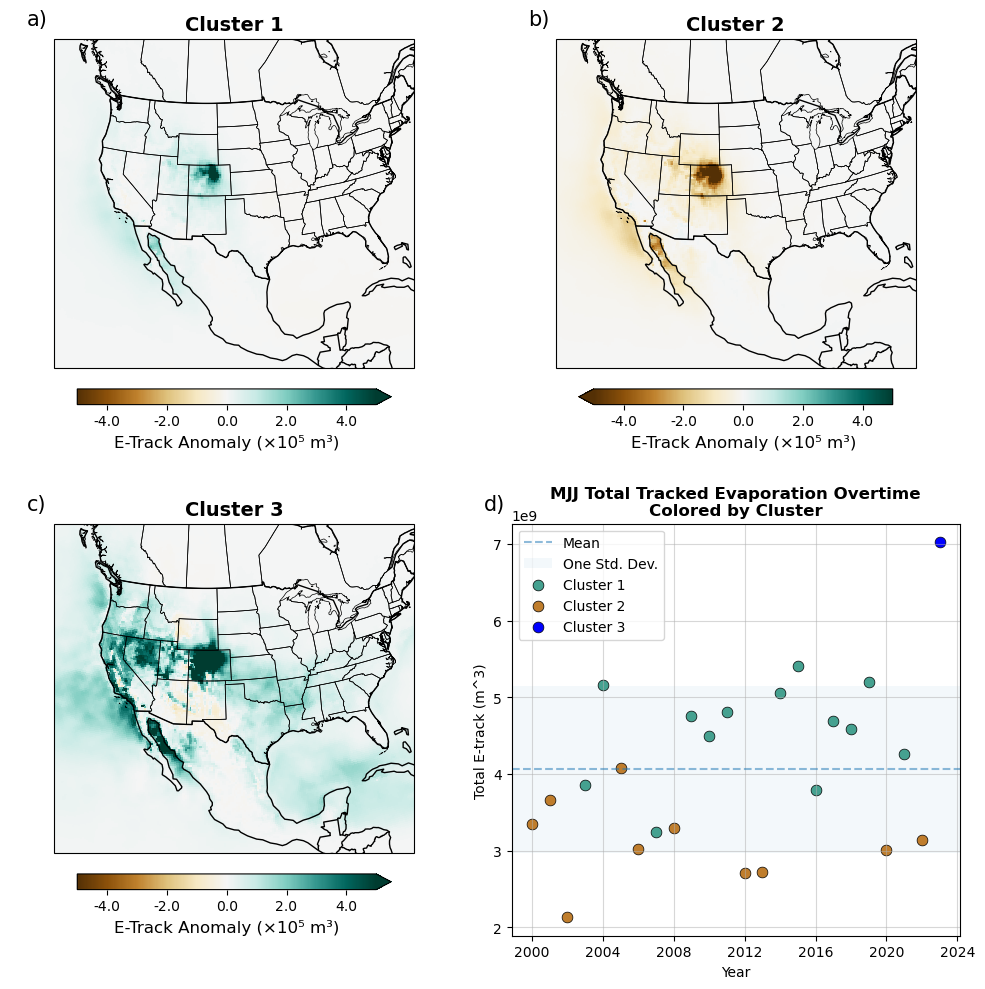

In [5]:
#modify----------------
maxVal = 500_000 #max value on colorbar in m^3
titleSize = 10 #font size
cmap_str = 'BrBG' 
extent = [-125, -80, 15, 55] #min lon, max lon, min lat, max lat in degrees
data_crs = ct.crs.PlateCarree() #data native projection
#-------------------------

#summarize to the total e-track in that year's summer
year_data = sum_may_june.resample(time = '1YS').sum().sum(['latitude', 'longitude'])['e_track']

#calc statistical vals
mean = year_data.mean()
std1 = [mean+(year_data.std()), mean-(year_data.std())]

#collect clustering information
cluster_means = []
cluster_indices = []

for i in range(1, numclust + 1):
    cluster_data = year_data.isel(time=(classes + 1) == i)
    cluster_means.append(cluster_data.mean().values)
    cluster_indices.append(i)

# sort clusters by wetness (ascending order: dry → wet → wettest)
sorted_pairs = sorted(zip(cluster_means, cluster_indices))  # ascending by mean E-track

# reassign clusters to match: Wet (Cluster 1), Dry (Cluster 2), Wettest (Cluster 3)
dry_idx = sorted_pairs[0][1]
wet_idx = sorted_pairs[1][1]
wettest_idx = sorted_pairs[2][1]

cluster_1 = year_data.isel(time=(classes + 1) == wet_idx)      # Cluster 1 = Wet
cluster_2 = year_data.isel(time=(classes + 1) == dry_idx)      # Cluster 2 = Dry
cluster_3 = year_data.isel(time=(classes + 1) == wettest_idx)  # Cluster 3 = Wettest
if numclust == 4:
    cluster_4 = year_data.isel(time=(classes + 1) == sorted_pairs[3][1])

# update cluster order for spatial plots
clusters_indx_change = [clusters[wet_idx - 1, :],      # cluster 1 = Wet
                        clusters[dry_idx - 1, :],      # cluster 2 = Dry
                        clusters[wettest_idx - 1, :]]   # cluster 3 = Wettest

#-------plotting---------
fig, axs =plt.subplots(2,2,figsize = (10,10))#,subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-106)})
axs = axs.flatten()
#turn off automatic axis for the maps
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")

fig_labels = ['a)', 'b)', 'c)', 'd)']
#plot cluster avg
for clust_idx in range(0, numclust):
    
    axs[clust_idx] = plt.subplot(2, 2, clust_idx + 1, projection=ccrs.LambertConformal(central_longitude=-106))
    cluster = clusters_indx_change[clust_idx]
    cluster_plot = xr.DataArray(cluster.reshape(len(lat),len(lon)), coords=[lat, lon])
    plot = cluster_plot.plot(transform = ccrs.PlateCarree(), cmap = cmap_str,add_colorbar=False, ax = axs[clust_idx], vmax = maxVal)
    extend_val = get_colorbar_extend(cluster_plot, vmax = maxVal, vmin=-maxVal)
    cbar = plt.colorbar(plot, ax=axs[clust_idx], orientation='horizontal', pad=0.05, shrink=0.7, extend = extend_val)
    cbar.set_label('E-Track Anomaly (×10⁵ m³)', fontsize=12)
    # format the colorbar values with scaling by 10^6
    cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-5:.1f}'))
    axs[clust_idx].coastlines(resolution='110m', linewidth=1)
    axs[clust_idx].add_feature(ct.feature.STATES, linewidth=0.5)
    axs[clust_idx].add_feature(ct.feature.BORDERS, linewidth=1)
    axs[clust_idx].set_extent(extent, crs=ccrs.PlateCarree())
    # Title and layout
    axs[clust_idx].set_title(f'Cluster {clust_idx+1}', fontsize=14, weight='bold')
    axs[clust_idx].text(0.0, 1.0, fig_labels[clust_idx], transform=(axs[clust_idx].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),fontsize=15, va='bottom')

#plot scatter plot
scatter_colors = {'wettest':'blue','wet':'#45a190','dry':'#BF7D2C', 'black':'black'}
axs[3].axhline(mean, alpha = 0.5, linestyle = '--', label = 'Mean')
axs[3].axhspan(std1[1],std1[0],  alpha = 0.05, label= 'One Std. Dev.')

axs[3].scatter(cluster_1.time.values,cluster_1.values, color = scatter_colors['wet'], s = 60, label = 'Cluster 1', edgecolors='black', linewidths=0.5)
axs[3].scatter(cluster_2.time.values,cluster_2.values, color = scatter_colors['dry'], s = 60, label = 'Cluster 2', edgecolors='black', linewidths=0.5)
if numclust >= 3:
    axs[3].scatter(cluster_3.time.values,cluster_3.values, color = scatter_colors['wettest'], s = 60, label = 'Cluster 3', edgecolors='black', linewidths=0.5)
elif numclust >= 4:
    axs[3].scatter(cluster_4.time.values,cluster_4.values, color = scatter_colors['black'], s = 60, label = 'Cluster 3', edgecolors='black', linewidths=0.5)

axs[3].set_xlabel('Year')
axs[3].set_ylabel('Total E-track (m^3)')
axs[3].grid(alpha = 0.5)
axs[3].set_title('MJJ Total Tracked Evaporation Overtime\nColored by Cluster', {'fontsize':12, 'weight':'bold'})
axs[3].legend( loc='upper left') #bbox_to_anchor=(1.05, 1)
axs[3].text(0.0, 1.0, fig_labels[3], transform=(axs[3].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),fontsize=15, va='bottom')
 
#save figure   
plt.tight_layout()
plt.savefig(SAVE_DIRECTORY+f'{numclust}clusters_map.png', dpi = 500)
print('saved clusters figure')